In [1]:
import numpy as np
import torch
import cv2
import h5py
from matplotlib import pyplot as plt
import src.models as models

In [2]:
annotation_class_colors = np.array([[0,255,0],[128,0,128],[255,0,255],[0,0,255],[255,165,0],[255,0,0]])
annotation_class_names = np.array(['epithelium_n','stroma_n','epithelium_c','stroma_c','corpora_amylacea','blood'])
n_classes = len(annotation_class_names)

## Load core

In [3]:
corename = 's33_c070'
mask_filepath = rf'D:/datasets/pcuk2023_ftir_whole_core/mask/{corename}.png'
mask = cv2.imread(mask_filepath) / 255.0

annot_filepath = rf'D:/datasets/pcuk2023_ftir_whole_core/annotation/{corename}.png'
annot = cv2.imread(annot_filepath)[:,:,::-1] / 255.0

core_filepath = rf'D:/datasets/pcuk2023_ftir_whole_core/spectral/{corename}.h5'
f = h5py.File(core_filepath)
datacube = f['spectra'][:] * mask[:,:,0:1]
f.close()

print(f"Loaded core with shape: {datacube.shape} and mask with shape: {mask.shape} and annotations with shape {annot.shape}")

Loaded core with shape: (256, 256, 965) and mask with shape: (256, 256, 3) and annotations with shape (256, 256, 3)


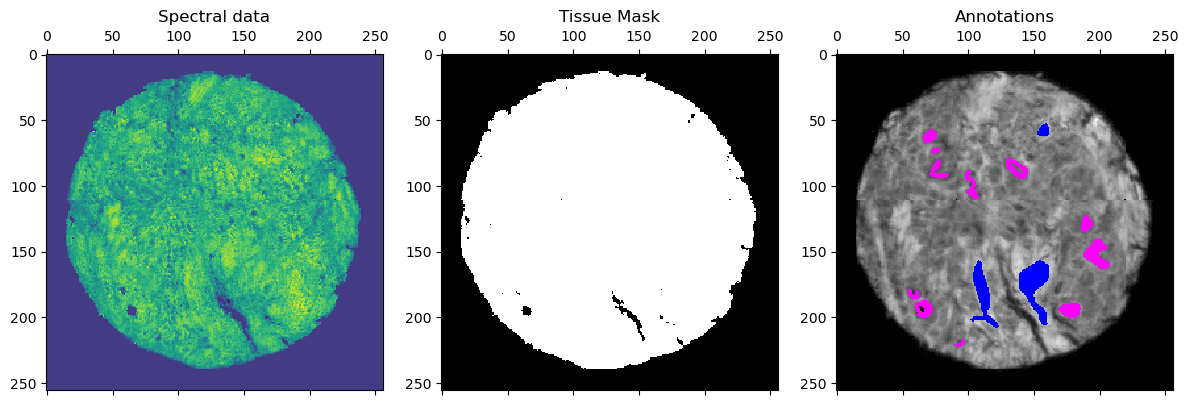

In [4]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].matshow(datacube[:,:,300]); ax[0].set_title("Spectral data")
ax[1].matshow(mask); ax[1].set_title("Tissue Mask")
ax[2].matshow(annot); ax[2].set_title("Annotations")
fig.tight_layout()

## Load model

In [5]:
model_use = 'blockvit'

if model_use == 'unet':
    model = models.UNet(965, 64, n_classes, 'linear')
    model.load_state_dict(torch.load(r'./model_weights/unet_linear_weights_55.pt',weights_only=True))
elif model_use == 'blockvit':
    model = models.BlockViT(965, 64, n_classes, 'linear',
        image_size=256,
        patch_size=16,
        num_layers=12,
        num_heads=12,
        hidden_dim=192,
        num_classes=n_classes,
        mlp_dim=192*4,
    )
    model.load_state_dict(torch.load(r'./model_weights/blockvit_linear_weights_55.pt',weights_only=True))
model.eval()

BlockViT(
  (conv_proj): Conv2d(64, 192, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=192, out_features=768, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=768, out_features=192, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (self_attention):

## Predict

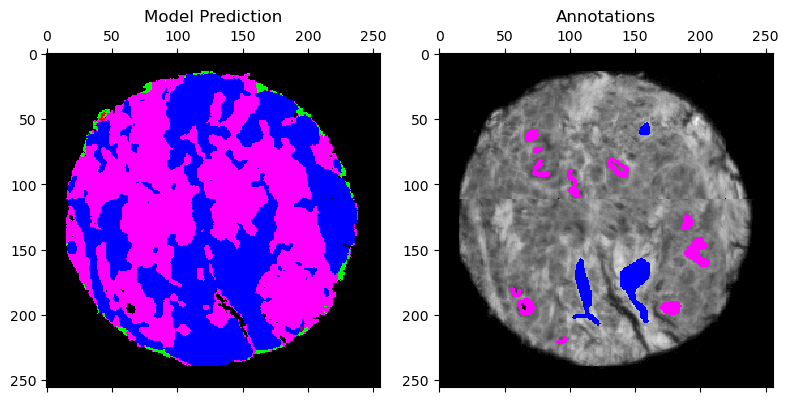

In [6]:
with torch.no_grad():
    out = model(torch.from_numpy(datacube).permute(2,0,1).unsqueeze(0).float())
pred = annotation_class_colors[out.squeeze().argmax(0)] * mask / 255.0

fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].matshow(pred); ax[0].set_title("Model Prediction")
ax[1].matshow(annot); ax[1].set_title("Annotations")
fig.tight_layout()

## Save output

In [7]:
cv2.imwrite(f'./pred_images/{model_use}_{corename}.png', np.rint(pred[..., ::-1] * 255.0))

True